# Décorrélation des effets environnementaux sur les mesures d’un capteur

### Ce Notebook Jupyter contient un cycle de vie de la science des données :

##### Extraire des données d'un fichier txt - Analyse exploratoire des données - Data Cleaning - Application des techniques KNN pour les valeurs nulles - Analyse de la corrélation - Machine Learning - Évaluation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Lecture et séparation des colonnes du fichier txt
df = pd.read_csv('C:/Users/vatsn/Downloads/SMF_DATA_TEST_TECHNIQUE/dataset.txt', sep=',')

print(df)

                TIMESTAMP deplacement  ensoleillement  temperature
0     2020-03-14 00:01:22         1.3             0.0     8.381906
1     2020-03-14 00:18:05         0.5             0.0     8.388235
2     2020-03-14 00:35:17         1.8             0.0     8.397227
3     2020-03-14 00:52:39         NAN             0.0     8.411952
4     2020-03-14 01:09:27         1.7             0.0     8.426197
...                   ...         ...             ...          ...
1843  2020-04-06 04:53:10         2.0             0.0    13.979392
1844  2020-04-06 05:11:04         2.1             0.0    13.866014
1845  2020-04-06 05:28:55         2.4             0.0    13.752952
1846  2020-04-06 05:46:51         2.2             0.0    13.772561
1847  2020-04-06 06:04:49         2.5             0.0    13.800787

[1848 rows x 4 columns]


# Exploratory Data Analysis

In [2]:
# Explorer les données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1848 entries, 0 to 1847
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TIMESTAMP       1848 non-null   object 
 1   deplacement     1848 non-null   object 
 2   ensoleillement  1848 non-null   float64
 3   temperature     1848 non-null   float64
dtypes: float64(2), object(2)
memory usage: 57.9+ KB


In [3]:
print(df.describe())

       ensoleillement  temperature
count     1848.000000  1848.000000
mean       249.395960    10.203553
std        371.006511     4.852275
min          0.000000    -0.044735
25%          0.000000     7.028316
50%         26.225605     9.576200
75%        386.176157    12.832483
max       1378.804382    27.206300


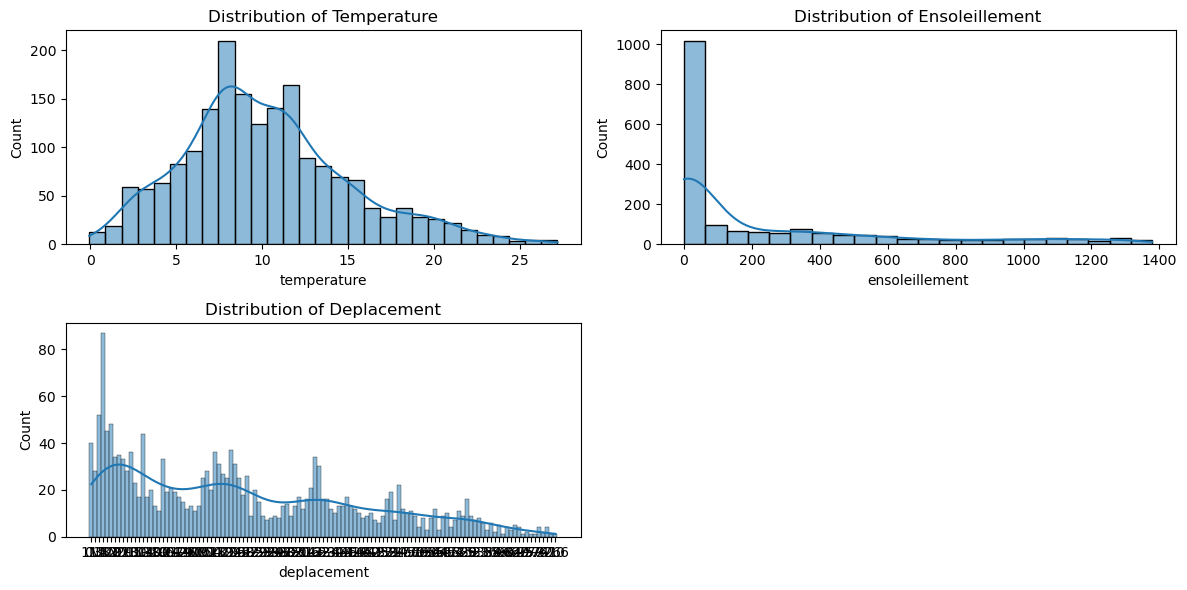

In [4]:
# Visualiser la distribution de chaque colonne
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.histplot(df['temperature'], kde=True)
plt.title('Distribution of Temperature')

plt.subplot(2, 2, 2)
sns.histplot(df['ensoleillement'], kde=True)
plt.title('Distribution of Ensoleillement')

plt.subplot(2, 2, 3)
sns.histplot(df['deplacement'], kde=True)
plt.title('Distribution of Deplacement')

plt.tight_layout()
plt.show()

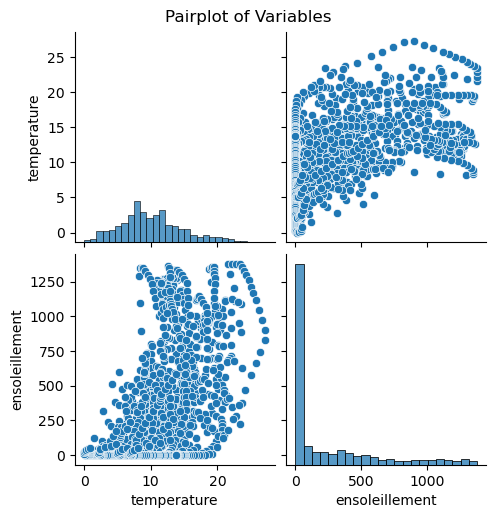

In [5]:
# Pairplot pour visualiser les relations entre les colonnes
sns.pairplot(df[['temperature', 'ensoleillement', 'deplacement']])
plt.suptitle('Pairplot of Variables', y=1.02)
plt.show()

# Data Cleaning

float64
There is  1.18 % null cell
deplacement    87
dtype: int64


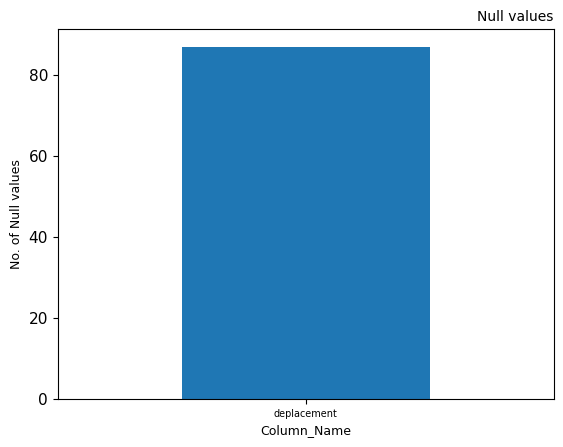

In [6]:
# Data Cleaning - Conversion des types de données nécessaires pour une analyse plus approfondie


# Conversion du 'déplacement' en float64, en remplaçant les valeurs non convertibles par NaN
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])

df['deplacement'] = pd.to_numeric(df['deplacement'], errors='coerce')
print(df['deplacement'].dtype)


# Détection des valeurs nulles grâce à la visualisation du plot et des numbers
def plot_nulldata(df:pd.DataFrame, title:str, xlabel:str, ylabel:str):
   
    total_size= df.size
    nullCount = df.isnull().sum()
    null_total = nullCount.sum()
    print("There is ", round(((null_total/total_size) * 100), 2), "%", "null cell")

    null = nullCount[nullCount > 0] 
    print(null)
    null.sort_values(inplace=True) 
    null.plot.bar()
    plt.title(title, size=10,loc='right')
    plt.xticks(fontsize=7,rotation=0)
    plt.yticks(fontsize=11)
    plt.xlabel(xlabel, fontsize=9)
    plt.ylabel(ylabel, fontsize=9)
    plt.show()
    
import matplotlib.pyplot as plt
plot_nulldata(df, 'Null values','Column_Name','No. of Null values')


# K-Nearest Neighbour(KNN) technique NULL values

#### J'ai choisi la technique d'imputation KNN pour remplir des valeurs nulles principalement pour 4 raisons :

- Il utilise les informations présentes dans l'ensemble de données pour imputer les valeurs manquantes. Cela peut être avantageux lorsque les données ont une structure spécifique, comme je pense que nous avons acquis nos données qui peuvent ne pas être capturées par des méthodes d'imputation plus génériques.

- L'imputation KNN ne suppose pas de linéarité des données. Il peut capturer des relations complexes et non linéaires entre les variables.

- L'imputation KNN est efficace pour gérer les relations multivariées. Il prend en compte plusieurs fonctionnalités simultanément lors de l'imputation de valeurs manquantes, de cette manière les valeurs nulles sont remplies d'un peu de confiance.

- L'imputation KNN est non paramétrique, ce qui signifie qu'elle ne suppose pas de distribution spécifique pour les données. C'est donc un choix sûr pour prédire les valeurs manquantes.

In [7]:
# Gérer les valeurs nulles avec KNN
# Sélection des fonctionnalités pour l'imputation KNN
features_for_imputation = df.select_dtypes(include=['float64'])

# Colonnes avec des valeurs nulles
target_column = 'deplacement'

# Rows avec des valeurs nulles
null_rows = df[target_column].isnull()

# Copie de Dataframe avec des valeurs nulles
df_imputed = df.copy()

# Application de l'imputation KNN
imputer = KNNImputer(n_neighbors=5)
df.loc[null_rows, [target_column]] = imputer.fit_transform(features_for_imputation)[null_rows, [features_for_imputation.columns.get_loc(target_column)]]

# Vérifier les modifications
print(df[target_column].isnull().sum())  

# Doit afficher 0 si l'imputation a réussi


0


# Data Visualization 

### Correlation Matrix

In [8]:
# Corrélation entre 'deplacement', 'ensoleillement', 'temperature'
for_correlation = df.select_dtypes(include=['float64', 'int64']).columns

# Corr2lation matrix
correlation_matrix = df[for_correlation].corr()

print(correlation_matrix)

                deplacement  ensoleillement  temperature
deplacement        1.000000       -0.889842    -0.740745
ensoleillement    -0.889842        1.000000     0.595670
temperature       -0.740745        0.595670     1.000000


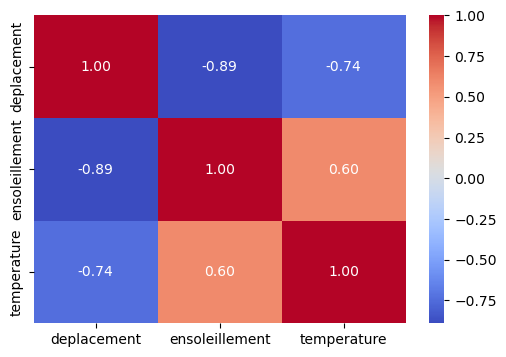

In [9]:

# Crée heatmap en utilisant Seaborn
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Affichage du plot
plt.show()

# Application de Independent Component Analysis(ICA) pour les variables de        décorrélation

##### L'objectif principal de l'ICA est de séparer un signal multivarié en composants additifs et indépendants. Ces composants représentent différentes sources ou facteurs sous-jacents contribuant aux données observées.

###### Ici, dans ce cas, j'ai choisi ICA pour décorréler chaque variable ou fonctionnalité afin d'atteindre l'objectif de déplacement de décorrélation.


In [10]:
# Sélection des colonnes pour l'analyse
X = df.iloc[:, 1:4]  

# Standardiser les données
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Appliquer l'ICA
ica = FastICA(n_components=3, random_state=42)  # You can adjust the number of components
independent_components = ica.fit_transform(X_standardized)

# Les components indépendants sont stockés dans independent_components
# Vous pouvez y accéder et analyser les résultats selon vos besoins


# Comparaison graphique de la matrice de corrélation avec les valeurs ICA

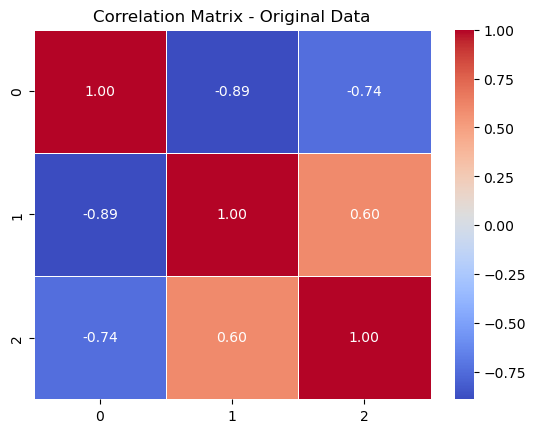

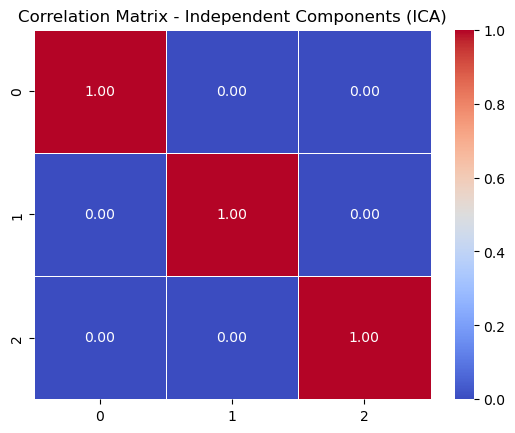

In [11]:

# X est les données d'origine et indépendant_components est le résultat de l'ICA
corr_original = np.corrcoef(X, rowvar=False)
corr_ica = np.corrcoef(independent_components, rowvar=False)


# Visualisation des matrices de corrélation
sns.heatmap(corr_original, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix - Original Data')
plt.show()

sns.heatmap(corr_ica, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix - Independent Components (ICA)')
plt.show()


# Machine Learning Algorithm

### Application Random Forest Regression
##### Il existe de nombreux cas d’utilisation du Random Forest Regression. Mais ici, dans notre cas, je voudrais définir le RFR comme PREDICTIVE ACCURACY et VARIABLE DECCORELATION IMPORTANCE.

#### Cela réduit également le OVERFITTING des données, ce qui, je pense, était important pour résoudre notre problème.

### Et par conséquent, cela donne le meilleur résultat.

In [12]:
# X contient les components independants sous forme de array NumPy et y contient la target variable
X = independent_components
y =  df['deplacement'].values

# Diviser les données en training et de testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser et training le modèle de Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Faire des prédictions sur test set
y_pred = rf_model.predict(X_test)


# Évaluation du modèle à l'aide Mean Squared Error 

Mean Squared Error: 0.06088731664864868


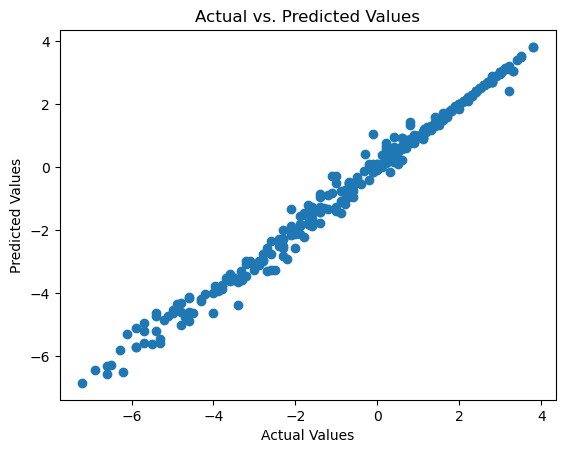

In [13]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Visualiser les predicted vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

# Conclusion

#### Le modèle prédictif développé pour la variable "déplacement" a fait preuve d'une précision louable, comme le montre la valeur de Mean Squared Error (MSE) de 0,06088. Cette faible MSE indique qu'en moyenne, les différences au carré entre les valeurs prédites et réelles sont minimes, ce qui souligne la capacité du modèle à capturer les modèles sous-jacents dans les données.

#### En termes simples, le modèle est assez précis et nous pouvons lui faire confiance pour faire de bonnes prédictions. C'est comme si nous disposions d'un outil fiable qui comprend les relations entre différents facteurs et peut nous aider à prédire le 'déplacement' avec précision.

#### Les implications de ce faible MSE sont significatives. Cela suggère que les prédictions du modèle s'alignent étroitement sur les valeurs réelles, ce qui signifie une solide compréhension des relations entre les caractéristiques et la variable cible. La précision obtenue par le modèle donne confiance dans sa capacité à bien généraliser des data invisibles et à faire des prédictions fiables.

#### Une analyse plus approfondie, y compris l'importance des fonctionnalités et les considérations spécifiques au domaine, peut améliorer notre compréhension des points forts du modèle et des domaines potentiels d'amélioration.

#### Compte tenu du délai, j'aimerais également faire une analyse plus approfondie en séparant TIME et DATE.

In [14]:
df23 = df.loc[:, ['TIMESTAMP']]

# Extract relevant features
df23['year'] = df23['TIMESTAMP'].dt.year
df23['month'] = df23['TIMESTAMP'].dt.strftime('%B')
df23['day'] = df23['TIMESTAMP'].dt.day
df23['weekday_name'] = df23['TIMESTAMP'].dt.day_name()
df23['hour'] = df23['TIMESTAMP'].dt.hour
df23['minute'] = df23['TIMESTAMP'].dt.minute
df23['second'] = df23['TIMESTAMP'].dt.second

print(df23)

               TIMESTAMP  year  month  day weekday_name  hour  minute  second
0    2020-03-14 00:01:22  2020  March   14     Saturday     0       1      22
1    2020-03-14 00:18:05  2020  March   14     Saturday     0      18       5
2    2020-03-14 00:35:17  2020  March   14     Saturday     0      35      17
3    2020-03-14 00:52:39  2020  March   14     Saturday     0      52      39
4    2020-03-14 01:09:27  2020  March   14     Saturday     1       9      27
...                  ...   ...    ...  ...          ...   ...     ...     ...
1843 2020-04-06 04:53:10  2020  April    6       Monday     4      53      10
1844 2020-04-06 05:11:04  2020  April    6       Monday     5      11       4
1845 2020-04-06 05:28:55  2020  April    6       Monday     5      28      55
1846 2020-04-06 05:46:51  2020  April    6       Monday     5      46      51
1847 2020-04-06 06:04:49  2020  April    6       Monday     6       4      49

[1848 rows x 8 columns]
